## Imports

In [35]:
import pyfar as pf
import sofar as sof
import matplotlib.pyplot as plt
import numpy as np
import os
import sofar as sof
import librosa
import soundfile as sf
from scipy.special import sph_harm
from pysofaconventions import SOFAFile

## Helper Functions

In [2]:
def deg2rad(deg):
    return deg * np.pi / 180

def rad2deg(rad):  
    return rad * 180 / np.pi        

## Simple HRTF Distance Extrapolation

In [162]:
# Initial delay for HUTUBS HRIRs measured at 1.47m radius
measured_radius = 1.47

def distance_gain(ir, distance):
    # Scales impulse response for the given distance
    g = measured_radius / distance
    return g * ir

## Pyfar HRIR Convolution

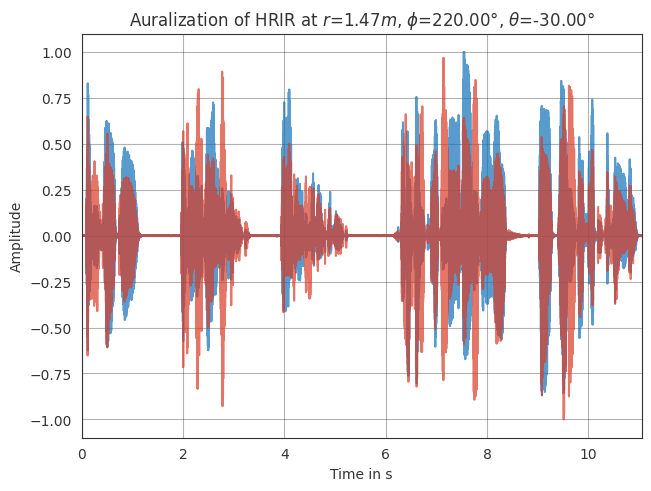

In [163]:
hrirs, sources, _ = pf.io.read_sofa(os.path.join('..', 'assets', 'pp2_HRIRs_measured.sofa'))

signal, sr = librosa.load(os.path.join('..', 'tests', 'input.wav'), sr=44100, mono=False)

idx = 332
hrir = hrirs[idx]
source = sources[idx]
radius, azimuth, elevation = *source.radius, *source.azimuth, *source.elevation

signal = pf.Signal(signal, sr)
auralization = pf.dsp.convolve(hrir, signal)
auralization = pf.dsp.normalize(auralization)

sf.write(os.path.join('..', 'tests', 'output', f'auralization_pp2_HRIRs_measured_{idx}.wav'), auralization.time.T, sr)

ax = pf.plot.time(auralization, label='convolved')
for line in ax.lines: line.set_alpha(0.7)
ax.set_title(fr'Auralization of HRIR at $r$={radius:.2f}$m$, $\phi$={rad2deg(azimuth):.2f}°, $\theta$={(rad2deg(elevation)):.2f}°')
plt.show()

## Check HRTF Source Angles

In [36]:
file = os.path.join(
    r'..',  'assets', 'pp2_HRIRs_measured.sofa')

# Read with sofar to get convention and version
sofa = SOFAFile(file, 'r')
# Get the values of a specific variable
values = sofa.getSourcePositionValues()

# # Print the values
# for i in range(len(values[0])):
#     print(values[:,i])

azimuths = set(values[:,0])
elevations = set(values[:,1])

azimuths



{0.0,
 10.0,
 12.0,
 15.0,
 20.0,
 24.0,
 30.0,
 36.0,
 40.0,
 45.0,
 48.0,
 50.0,
 60.0,
 70.0,
 72.0,
 75.0,
 80.0,
 84.0,
 90.0,
 96.0,
 100.0,
 105.0,
 108.0,
 110.0,
 120.0,
 130.0,
 132.0,
 135.0,
 140.0,
 144.0,
 150.0,
 156.0,
 160.0,
 165.0,
 168.0,
 170.0,
 180.0,
 190.0,
 192.0,
 195.0,
 200.0,
 204.0,
 210.0,
 216.0,
 220.0,
 225.0,
 228.0,
 230.0,
 240.0,
 250.0,
 252.0,
 255.0,
 260.0,
 264.0,
 270.0,
 276.0,
 280.0,
 285.0,
 288.0,
 290.0,
 300.0,
 310.0,
 312.0,
 315.0,
 320.0,
 324.0,
 330.0,
 336.0,
 340.0,
 345.0,
 348.0,
 350.0}

## SH Interpolation

In [49]:
file = os.path.join(
    r'..',  'assets', 'pp2_HRIRs_measured.sofa')
hrirs, sg, _ = pf.io.read_sofa(file)

# Read with sofar to get convention and version
sofa = sof.read_sofa(file)
convention = sofa._convention["GLOBAL_SOFAConventions"]["default"]
version = sofa._convention["GLOBAL_SOFAConventionsVersion"]["default"]

# Order
N = 20
# Sampling Points
Q = sg.cshape[0]

# Generate order (n) and degree (m) indices
n = np.array([])
m = np.array([])
for nn in range(N+1):
    n = np.append(n, nn * np.ones(2*nn+1))
    m = np.append(m, np.arange(-nn, nn+1))

Y = sph_harm(
    m[None, ...], n[None, ...],
    sg.azimuth[..., None], sg.colatitude[..., None])

Y_inv = np.linalg.pinv(Y)

# SH transform
f_nm = pf.matrix_multiplication((Y_inv, hrirs))

# Equidistant spherical sampling grid
grid = pf.samplings.sph_extremal(n_points=None, sh_order=80, radius=1.47)

# Compute new Y to get hrirs at unknow locations
Y2 = sph_harm(
    m[None, ...], n[None, ...],
    grid.azimuth[..., None], grid.colatitude[..., None])

# Inverse SH transform
hrirs_sh = pf.matrix_multiplication((Y2, f_nm))

# Create new sofa object for writing interpolated HRIR
sofa = sof.Sofa(convention=convention, version=version)
sofa.Data_IR = hrirs_sh.time
sofa.Data_SamplingRate = 44100.0

 # Convert grid to spherical_elevation in degree for the sofa object
deg_grid = grid.spherical_elevation.copy()
deg_grid[:, 0] = rad2deg(grid.spherical_elevation[:, 0]) 
deg_grid[:, 1] = rad2deg(grid.spherical_elevation[:, 1]) 
sofa.SourcePosition = deg_grid

# Save sofar object as sofar file
file = os.path.join(
    r'..',  'assets', 'pp2_HRIRs_measured_interpolated.sofa')
sof.write_sofa(file, sofa,compression=0)


## Visualize Sampling Grids 

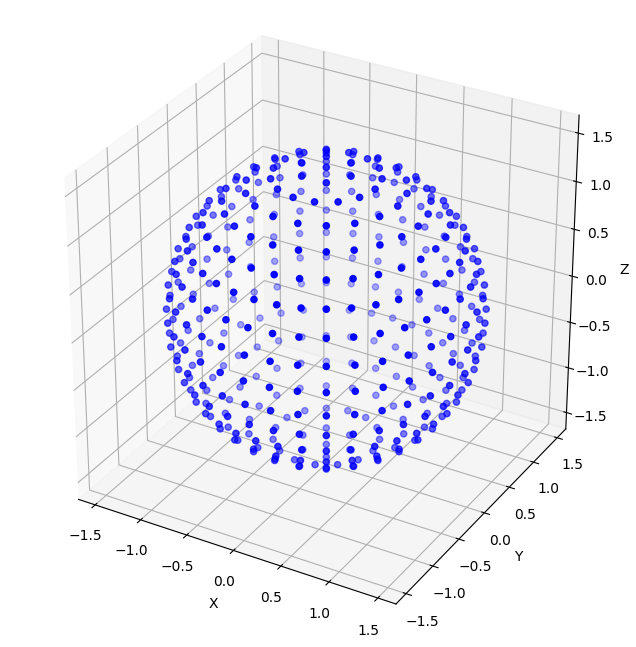

In [34]:
file = os.path.join(
    r'..',  'assets', 'pp2_HRIRs_measured.sofa')
# file = os.path.join(
#     r'..',  'assets', 'pp2_HRIRs_measured_interpolated.sofa')

# Load grid from sofa file
hrirs, grid, _ = pf.io.read_sofa(file)

# Create grid
# grid = pf.samplings.sph_extremal(n_points=None, sh_order=80, radius=1.47)
x, y, z = grid.x, grid.y, grid.z

# Plot the grid
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='blue', s=20)

# Set the aspect ratio to be equal
ax.set_box_aspect([1, 1, 1])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()